## QVNE - Solving VNE with VQE approach
### Yasaman Parhizkar - 810195559
#### Fall 1399

In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

# Qiskit packages
from qiskit import BasicAer
from qiskit.quantum_info import Pauli
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators import WeightedPauliOperator

# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

#### Problem Setup

In [2]:
# Setup subtrate and virtual network
class Initializer():

    def __init__(self, min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf):
        
        self.min_V_size = min_V_size
        self.max_V_size = max_V_size
        self.min_cpu_cap = min_cpu_cap
        self.max_cpu_cap = max_cpu_cap
        self.min_bw_cap = min_bw_cap
        self.max_bw_cap = max_bw_cap
        self.inf = inf
        
        self.rnd = np.random
        
    def generate_problem(self):
        
        rnd = self.rnd
        
        [n, m] = rnd.randint(low = min_V_size, high = max_V_size + 1, size = 2)
        if n < m:
            (m, n) = (n, m)
        
        SN = self.generate_random_graph(n)
        VN = self.generate_random_graph(m)
        
        return (SN, VN)
        
    def generate_random_graph(self, n):
        
        rnd = self.rnd
        
        V = [i for i in range(n)]
        E = [(i, j) for i in V for j in V if i < j and rnd.randint(0,2) == 1]
        E.extend([(j, i) for (i, j) in E])
        T = {i: rnd.randint(min_cpu_cap, max_cpu_cap + 1) for i in V}
        D = {(i, j): rnd.randint(min_bw_cap, max_bw_cap + 1) for (i, j) in E if i < j}
        D.update({(j, i): D[i, j] for (i, j) in D})
        
        return (V, E, T, D)

    def generate_instance(self, n, D):
        
        inf = self.inf

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.ones([n, n]) * inf
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                if (ii, jj) in D:
                    instance[ii, jj] = D[ii, jj]
                    instance[jj, ii] = D[jj, ii]

        return xc, yc, instance
    
    def visualize_graph(self, xc, yc, instance, B, K, n, title_str, show_weights = True):
        
        instance = instance.reshape(n ** 2)
        
        plt.figure()
        plt.scatter(xc, yc, s=200)
        for i in range(len(xc)):
            plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
            
            if show_weights:
                plt.annotate(B[i], (xc[i] + 0.15, yc[i] - 0.45), size=16, color='g')

        plt.grid()

        for ii in range(0, n ** 2):

            if instance[ii] < inf:
                ix = ii // n
                iy = ii % n
                plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], linewidth=2)
                
                if show_weights:
                    plt.annotate(K[ix, iy], (0.5*(xc[ix] + xc[iy]), 0.5*(yc[ix] + yc[iy])), size=16, color='b')

        plt.title(title_str)
        plt.show()

n = 4, m = 3

Subtrate network:
V0 = [0, 1, 2, 3]
E0 = [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (2, 0), (3, 0), (2, 1), (3, 1), (3, 2)]
B = {0: 4, 1: 6, 2: 3, 3: 5}
K = {(0, 2): 8, (0, 3): 7, (1, 2): 9, (1, 3): 9, (2, 3): 2, (2, 0): 8, (3, 0): 7, (2, 1): 9, (3, 1): 9, (3, 2): 2}
instance_sn = [[2.5e+03 2.5e+03 8.0e+00 7.0e+00]
 [2.5e+03 2.5e+03 9.0e+00 9.0e+00]
 [8.0e+00 9.0e+00 2.5e+03 2.0e+00]
 [7.0e+00 9.0e+00 2.0e+00 2.5e+03]]

***

Virtual network:
V1 = [0, 1, 2]
E1 = [(0, 2), (1, 2), (2, 0), (2, 1)]
T1 = {0: 9, 1: 2, 2: 6}
D1 = {(0, 2): 10, (1, 2): 9, (2, 0): 10, (2, 1): 9}
instance_vn = [[2500. 2500.   10.]
 [2500. 2500.    9.]
 [  10.    9. 2500.]]


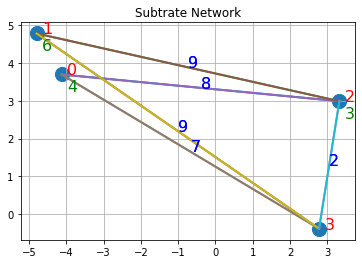

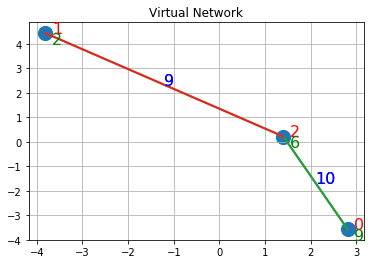

In [3]:
# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 5
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10
inf = max_bw_cap * (max_V_size ** 2) * 10

np.random.seed(0)

# Construct the graphs of the problem
initializer = Initializer(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf)
(SN, VN) = initializer.generate_problem()
n = len(SN[0])
m = len(VN[0])
xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

print("n = " + str(n) + ", m = " + str(m) + "\n")

# Show substrate network
print("Subtrate network:")
print("V0 = " + str(SN[0]))
print("E0 = " + str(SN[1]))
print("B = " + str(SN[2]))
print("K = " + str(SN[3]))
print("instance_sn = " + str(instance_sn))
print("\n***\n")

# Show virtual network
print("Virtual network:")
print("V1 = " + str(VN[0]))
print("E1 = " + str(VN[1]))
print("T1 = " + str(VN[2]))
print("D1 = " + str(VN[3]))
print("instance_vn = " + str(instance_vn))

initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], SN[3], n, "Subtrate Network")
initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], VN[3], m, "Virtual Network")

#### Node Mapping

In [4]:
class NodeMap:
    
    def __init__(self, SN, VN):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3]
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
    
    # First policy: max demand node -> max capacity node
    def map_p1(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V1 = self.V1
        
        sorted_B = sorted(B.items(), key=lambda kv: kv[1], reverse = True)
        sorted_T1 = sorted(T1.items(), key=lambda kv: kv[1], reverse = True)
        node_map = {sorted_T1[i][0]: sorted_B[i][0] for i in range(len(V1))}
        
        if not self.is_feasible(node_map):            
            if show_results:
                print("Wrong node map: " +  str(node_map))
            for i in node_map:
                node_map[i] = -1
        
        return node_map
    
    # Second policy: each node in sequence -> colsest capacity to the demand of that node
    def map_p2(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        V0 = self.V0
        V1 = self.V1
        
        node_map = {i: 0 for i in range(len(V1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        
        for i in V1:
            j = np.argmin(np.power(B_v - np.ones(len(B_v)) * T1[i], 2))
            node_map[i] = B_k[j]
            B_k.pop(j)
            B_v.pop(j)
            
        if not self.is_feasible(node_map):             
            if show_results:
                print("Wrong node map: " +  str(node_map))
            for i in node_map:
                node_map[i] = -1
        
        return node_map
    
    # Third policy: summation of differences between node capacities and demands will be minimum
    def map_p3(self, show_results = True):
        
        B = self.B
        T1 = self.T1
        
        # initialization
        node_map = {i: -1 for i in range(len(T1))}
        B_k = [i for (i, j) in B.items()]
        B_v = [j for (i, j) in B.items()]
        T_k = [i for (i, j) in T1.items()]
        T_v = [j for (i, j) in T1.items()]
        inf = (max(B_v) + 1) ** 2

        while T_v != []:

            nn = len(B_v)
            mm = len(T_v)

            # get the distances of each VN node's demand to each SN node's capacity
            distances = np.power(np.kron(np.ones(mm), B_v) - np.kron(T_v, np.ones(nn)), 2)
            distances = distances.reshape(mm, nn)
            decision = np.ones((mm, nn)) * inf
            
            # row-wise minimization
            for ii in range(mm):
                jmin = np.argmin(distances[ii])
                decision[ii][jmin] = distances[ii][jmin]

            # column-wise minimization
            for jj in range(nn):

                temp = [decision[i][jj] for i in range(mm)]
                imin = np.argmin(temp)
                if temp[imin] < inf:
                    node_map[T_k[imin]] = B_k[jj]
            
            # reconstruct B and T based on yet un-mapped nodes
            for ii in node_map:
                if node_map[ii] != -1 and ii in T_k:

                    T_v.pop(T_k.index(ii))
                    T_k.remove(ii)

                    jj = node_map[ii]
                    B_v.pop(B_k.index(jj))
                    B_k.remove(jj)
        
        if not self.is_feasible(node_map):             
            if show_results:
                print("Wrong node map: " +  str(node_map))
            for i in node_map:
                node_map[i] = -1
                    
        return node_map
    
    def is_feasible(self, node_map):
        
        B = self.B
        T1 = self.T1
        
        for i in node_map:
            if B[node_map[i]] < T1[i]:
                return False
        
        return True

In [5]:
# Map nodes of virtual network to subtrate network (three policies are available)
node_map = NodeMap(SN, VN)
nm = node_map.map_p3()
print("Map of VN nodes -> SN nodes = " + str(nm))

Wrong node map: {0: 3, 1: 2, 2: 1}
Map of VN nodes -> SN nodes = {0: -1, 1: -1, 2: -1}


#### Link Mapping
We use quantum optimization for this part.

   * First, we find an optimized path for one link and then repeat the process for every link in VN.

In [6]:
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:

    def __init__(self, instance_sn, src, des, n, inf):

        self.instance_sn = instance_sn
        self.src = src
        self.des = des
        self.n = n
        self.inf = inf

    def binary_representation(self,x_sol=0):

        instance_sn = self.instance_sn
        src = self.src
        des = self.des
        n = self.n
        inf = self.inf

        A = inf  # A parameter of cost function = inf

        # Determine the weights w
        instance_vec = instance_sn.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if x//n != x%n]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[src] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1
        Iy_n = Id_n
        Iy_n[src][src] = 0
        Iy_n[des][des] = 0

        v = np.zeros([n, n*(n-1)])
        for ii in range(n):
            count = ii-1
            for jj in range(n*(n-1)):

                if jj//(n-1) == ii:
                    count = ii

                if jj//(n-1) != ii and jj%(n-1) == count:
                    v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v) - 2*np.dot(np.kron(Iy_n, Iv_n).T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(neg_Iv_n_1, Iv_n) + v[des].T)

        # c is the constant offset
        c = 2 * A

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        aqua_globals.random_seed = 10598
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=aqua_globals.random_seed,
                                           seed_transpiler=aqua_globals.random_seed)

        vqe = VQE(quantum_instance=quantum_instance)
        optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        return result.x, level

In [7]:
class LinkMap:
    
    def __init__(self, SN, VN, instance_sn, node_map, inf):
        
        self.V0 = SN[0]
        self.E0 = SN[1]
        self.B = SN[2]
        self.K = SN[3]
        self.V1 = VN[0]
        self.E1 = VN[1]
        self.T1 = VN[2]
        self.D1 = VN[3]
        self.instance_sn = instance_sn
        self.node_map = node_map
        self.inf = inf
    
    # Get requested links on substrate network
    def get_links(self):
        
        E1 = self.E1
        
        node_map = self.node_map
        
        return [(node_map[i], node_map[j]) for (i, j) in E1]
    
    def get_route(self, src, des):
        
        instance_sn = self.instance_sn
        inf = self.inf
        V0 = self.V0
        
        n = len(V0)
        
        # Instantiate the quantum optimizer class with parameters:
        quantum_optimizer = QuantumOptimizer(instance_sn, src, des, n, inf)
        
        z = None
        # Check if the binary representation is correct
        try:
            if z is not None:
                Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol = z)
                print("Binary cost:", binary_cost, "classical cost:", classical_cost)
                if np.abs(binary_cost - classical_cost) < 0.01:
                    print('Binary formulation is correct')
                else: print('Error in the binary formulation')
            else:
                print('_Could not verify the correctness, due to CPLEX solution being unavailable.')
                Q, g, c, binary_cost = quantum_optimizer.binary_representation()
                print("_Binary cost:", binary_cost)
        except NameError as e:
            print("Warning: Please run the cells above first.")
            print(e)
        
        qp = quantum_optimizer.construct_problem(Q, g, c)
        
        quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

        return quantum_solution, quantum_cost
    
    def map_links(self):
        
        links = self.get_links()
        
        lm = {(i, j): ([], -1) for (i, j) in links if i < j}
        
        for (i, j) in lm:
            lm[(i, j)] = self.get_route(i, j)
            
        return lm
        
    def display_map(self, lm):
        
        node_map = self.node_map
        
        rev_node_map = {node_map[i]: i for i in node_map}        
        VN_edges = {(i, j): (rev_node_map[i], rev_node_map[j]) for (i, j) in lm}
        
        print("\nLink Map:")
        print("VN edge","SN edge", "cost", "path in SN", sep = '\t\t')
        print("-----------------------------------------------------------------------------")
        for (i, j) in lm:
            print(VN_edges[(i, j)], end = '\t\t')
            print('('+str(i)+", "+str(j)+')', end = '\t\t')
            print(lm[(i, j)][1], end = '\t\t')
            print(lm[(i, j)][0], end = '\n')
            
        print("-----------------------------------------------------------------------------")

In [8]:
# Map edges of virtual network to paths in substrate network

linkmap = LinkMap(SN, VN, instance_sn, nm, inf)

links = linkmap.get_links()
print("Links between these nodes should be found in SN (Equivalents of VN edges):")
print(links)
print(' ')

lm = linkmap.map_links() # Caution: This line takes time to run.
linkmap.display_map(lm)

Links between these nodes should be found in SN (Equivalents of VN edges):
[(-1, -1), (-1, -1), (-1, -1), (-1, -1)]
 

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------


#### Gathering it all in one object

In [9]:
class QVNE:
    
    def __init__(self, min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf):
        
        self.min_V_size = min_V_size
        self.max_V_size = max_V_size
        self.min_cpu_cap = min_cpu_cap
        self.max_cpu_cap = max_cpu_cap
        self.min_bw_cap = min_bw_cap
        self.max_bw_cap = max_bw_cap
        self.inf = inf
        
        self.SN = ()
        self.VN = ()
        self.xc_sn = []
        self.yc_sn = []
        self.xc_vn = []
        self.yc_vn = []
        self.instance_sn = []
        self.instance_vn = []
        self.n = 0
        self.m = 0
        
        self.nm = {}
        self.lm = {}
        self.links = []
    
    # Setup the problem
    def setup_problem(self, show_results = True):
        
        min_V_size = self.min_V_size
        max_V_size = self.max_V_size
        min_cpu_cap = self.min_cpu_cap
        max_cpu_cap = self.max_cpu_cap
        min_bw_cap = self.min_bw_cap
        max_bw_cap = self.max_bw_cap
        inf = self.inf
        
        # Construct the graphs of the problem
        initializer = Initializer(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf)
        (SN, VN) = initializer.generate_problem()
        
        n = len(SN[0])
        m = len(VN[0])

        xc_sn, yc_sn, instance_sn = initializer.generate_instance(n, SN[3])
        xc_vn, yc_vn, instance_vn = initializer.generate_instance(m, VN[3])

        if show_results:
            initializer.visualize_graph(xc_sn, yc_sn, instance_sn, SN[2], SN[3], n, "Subtrate Network")
            print("n = " + str(n))
        
            initializer.visualize_graph(xc_vn, yc_vn, instance_vn, VN[2], VN[3], m, "Virtual Network")
            print("m = " + str(m))
        
        self.SN = SN
        self.VN = VN
        self.xc_sn = xc_sn
        self.yc_sn = yc_sn
        self.xc_vn = xc_vn
        self.yc_vn = yc_vn
        self.instance_sn = instance_sn
        self.instance_vn = instance_vn
        self.n = n
        self.m = m
    
    # Map nodes of virtual network to subtrate network (three policies are available)   
    def node_map(self, policy = 1, show_results = True):
        
        SN = self.SN
        VN = self.VN
        
        B = SN[2]
        T1 = VN[2]
        
        node_map = NodeMap(SN, VN)
        if policy == 1:
            nm = node_map.map_p1(show_results)
        elif policy == 2:
            nm = node_map.map_p2(show_results)
        elif policy == 3:
            nm = node_map.map_p3(show_results)
        else:
            print("Error: Policy number should be one of 1, 2, 3 options.")
            return {}
        
        if nm == -1:
            if show_results:
                print("Node mapping was unsuccessful.")
            return -1
        
        self.nm = nm
        
        if show_results:
            print("Map of VN nodes -> SN nodes = " + str(nm))
        
        return nm
    
    # Map edges of virtual network to paths in substrate network
    def link_map(self, show_results = True):
        
        SN = self.SN
        VN = self.VN
        instance_sn = self.instance_sn
        nm = self.nm
        
        linkmap = LinkMap(SN, VN, instance_sn, nm, inf)

        links = linkmap.get_links()
        
        lm = linkmap.map_links() # Caution: This line takes time to run.
        
        if show_results:
            print("Links between these nodes should be found in SN (Equivalents of VN edges):")
            print(links)
            print(' ')
            linkmap.display_map(lm)
        
        self.lm = lm
        self.links = links
        
        return lm, links
    
    # Visualize the optimized route on SN using its x vector
    def visualize_route(self, src, des):
        
        xc_sn = self.xc_sn
        yc_sn = self.yc_sn
        lm = self.lm
        n = self.n
        
        if (src, des) not in lm:
            print("Error: No link between (" + str(src) + ", " + str(des) + ") is found in this problem's link map.")
            return
        
        # Get the requested route
        x = lm[(src, des)][0]
        C = lm[(src, des)][1]
        
        # Put the solution in a way that is compatible with the classical variables
        x_quantum = np.zeros(n ** 2)
        kk = 0
        for ii in range(n ** 2):
            if ii // n != ii % n:
                x_quantum[ii] = x[kk]
                kk +=  1  
        
        plt.figure()
        plt.scatter(xc_sn, yc_sn, s=200)
        
        for i in range(len(xc_sn)):
            plt.annotate(i, (xc_sn[i] + 0.15, yc_sn[i]), size=16, color='r')

        plt.grid()

        for ii in range(0, n ** 2):

            if x_quantum[ii] > 0:
                ix = ii // n
                iy = ii % n
                plt.arrow(xc_sn[ix], yc_sn[ix], xc_sn[iy] - xc_sn[ix], yc_sn[iy] - yc_sn[ix], \
                          length_includes_head=True, head_width=.25)

        plt.title('Link '+ str((src, des)) + ', Cost = ' + str(int(C * 100) / 100.))
        plt.show()
        
    def is_success(self):
        
        nm = self.nm
        lm = self.lm
        inf = self.inf
        
        if nm[0] == -1:
            return False
        
        for (i, j) in lm:
            if lm[(i, j)][1] >= inf:
                return False
        
        return True
    
    def set_links(self, links):
        
        self.links = links
        
    def set_lm(self, lm):
        
        self.lm = lm
        
    def run(self, nm_policy = 1, show_results = True):
        
        if show_results:
            print("* Seting up the problem:")
        self.setup_problem(show_results)

        if show_results:
            print("\n* Node mapping:")
        nm = self.node_map(policy = nm_policy, show_results = show_results)
        
        if nm[0] == -1:
            return False

        if show_results:
            print("\n* Link mapping:")
        _, links = self.link_map(show_results)
        
        if show_results:
            print("\n* Visualize optimized route for every link:")
            for (i, j) in links:
                if i < j:
                    qvne.visualize_route(i, j)
            
        success = qvne.is_success()
        
        if show_results:
            print("Success: " + str(success))
            
        return success
    
    def success_ratio(self, nm_policy = 1, shots = 3):
        
        count = 0
        for ii in range(shots):
            
            np.random.seed(ii)
            
            if self.run(nm_policy = nm_policy, show_results = False):
                count = count + 1
                
        return ((count * 1.)/shots)
        

* Seting up the problem:


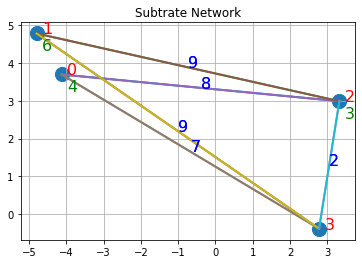

n = 4


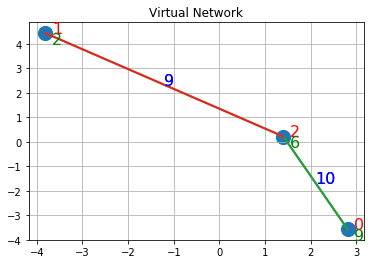

m = 3

* Node mapping:
Wrong node map: {0: 1, 2: 3, 1: 0}
Map of VN nodes -> SN nodes = {0: -1, 2: -1, 1: -1}

* Link mapping:
Links between these nodes should be found in SN (Equivalents of VN edges):
[(-1, -1), (-1, -1), (-1, -1), (-1, -1)]
 

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------


In [10]:
# Do it all agian using the integrated class of QVNE

# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 5
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10
inf = max_bw_cap * (max_V_size ** 2) * 10

np.random.seed(0)


qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf)

print("* Seting up the problem:")
qvne.setup_problem()

print("\n* Node mapping:")
nm = qvne.node_map(policy = 1)

print("\n* Link mapping:")
lm, links = qvne.link_map()

In [11]:
# qvne.set_links(links)
# qvne.set_lm(lm)

print("\n* Visualize optimized route for every link:")
for (i, j) in links:
    if i < j:
        qvne.visualize_route(i, j)

print(qvne.is_success())


* Visualize optimized route for every link:
False


* Seting up the problem:


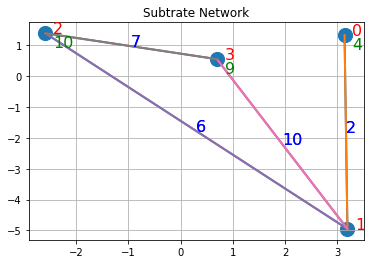

n = 4


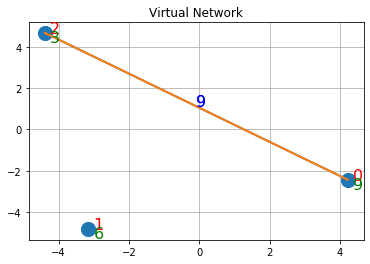

m = 3

* Node mapping:
Map of VN nodes -> SN nodes = {0: 2, 1: 3, 2: 1}

* Link mapping:
_Could not verify the correctness, due to CPLEX solution being unavailable.
_Binary cost: 0
Links between these nodes should be found in SN (Equivalents of VN edges):
[(2, 1), (1, 2)]
 

Link Map:
VN edge		SN edge		cost		path in SN
-----------------------------------------------------------------------------
(2, 0)		(1, 2)		-3184.0		[0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
-----------------------------------------------------------------------------

* Visualize optimized route for every link:


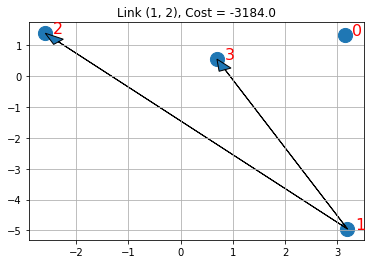

Success: True


True

In [12]:
# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 4
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10
inf = max_bw_cap * (max_V_size ** 2) * 10

np.random.seed(45)

qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf)
qvne.run(nm_policy = 1, show_results = True)

In [13]:
# Get success ratio of algorithm by running it 3 times

# Initialize the problem by defining the parameters
min_V_size = 3
max_V_size = 5
min_cpu_cap = 1
max_cpu_cap = 10
min_bw_cap = 1
max_bw_cap = 10
inf = max_bw_cap * (max_V_size ** 2) * 10

np.random.seed(0)

shots = 3
nm_policy = 1

qvne = QVNE(min_V_size, max_V_size, min_cpu_cap, max_cpu_cap, min_bw_cap, max_bw_cap, inf)
suc_ratio = qvne.success_ratio(nm_policy = nm_policy, shots = shots)

print("Success ratio after " + str(shots) + " runs = " + str(suc_ratio))

Success ratio after 3 runs = 0.0
